# Visualization & community detection

In [16]:
import networkx as nx
import math
import pandas as pd
import matplotlib.pyplot as plt

from cdlib import viz, algorithms
from cdlib.classes import NodeClustering
from collections import defaultdict

from stock_graph_creation import get_sp500_stocks, get_sp500_stocks_info
from stock_graph_creation import correlation_to_graph, correlation_to_pos_neg_graphs
from utils import info, plot_block_model, plot_wiring_diagram

In [5]:
stocks_info = get_sp500_stocks_info()
#correlations = get_sp500_stocks(start_date="2025-02-01", end_date="2025-03-01").corr()

In [6]:
correlations = pd.read_csv("stonks-2025-feb.csv")
correlations = correlations.drop(columns=["Ticker"])

## Analysis of different thresholds

Let's try different thresholds for constructing graphs from the correlations and compare these different graphs' properties.

In [7]:
def LCC(G):
    return nx.subgraph(G, max(nx.connected_components(G), key = len))


In [15]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds:
    G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, stocks_info, threshold)

    for graph, sign in [(G_pos, "positive"), (G_neg, "negative")]:
        num_nodes = graph.number_of_nodes()
        num_edges = graph.number_of_edges()

        avg_degree = 2 * num_edges / num_nodes
        max_degree = max(k for _, k in graph.degree())

        lcc = LCC(graph)
        lcc_percent = len(lcc) / num_nodes * 100

        clustering = nx.average_clustering(graph)

        results.append({
            "Threshold": threshold,
            "Graph type": sign,
            "Nodes": num_nodes,
            "Edges": num_edges,
            "Average degree": round(avg_degree, 1),
            "Largest degree": max_degree,
            "Largest CC %": round(lcc_percent, 1),
            "Clustering coeff.": round(clustering, 3)
        })

graph_stats_df = pd.DataFrame(results)
graph_stats_df

,Threshold,Graph type,Nodes,Edges,Average degree,Largest degree,Largest CC %,Clustering coeff.
0,0.5,positive,502,10678,42.5,133,99.2,0.399
1,0.5,negative,502,924,3.7,63,70.1,0.000
2,0.6,positive,502,4209,16.8,79,97.2,0.341
3,0.6,negative,502,216,0.9,26,26.1,0.000
4,0.7,positive,502,1313,5.2,42,74.7,0.237
5,0.7,negative,502,25,0.1,4,1.2,0.000
6,0.8,positive,502,277,1.1,16,17.9,0.097
7,0.8,negative,502,1,0.0,1,0.4,0.000
8,0.9,positive,502,19,0.1,4,1.2,0.005
9,0.9,negative,502,0,0.0,0,0.2,0.000


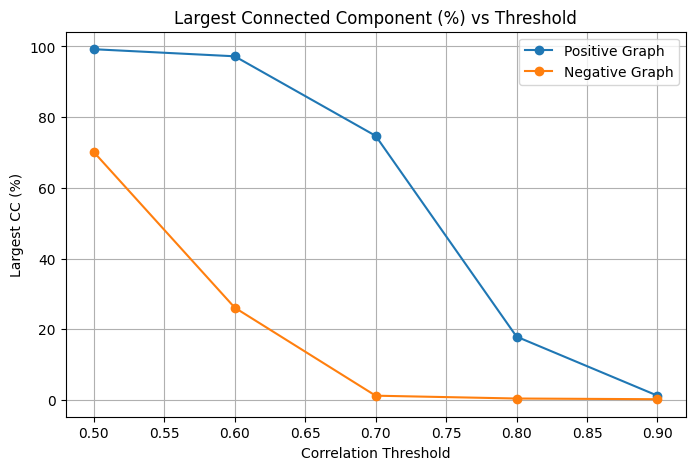

In [21]:
pivot_df = graph_stats_df.pivot(index='Threshold', columns='Graph type', values='Largest CC %')

plt.figure(figsize=(8, 5))
plt.plot(pivot_df.index, pivot_df['positive'], marker='o', label='Positive Graph')
plt.plot(pivot_df.index, pivot_df['negative'], marker='o', label='Negative Graph')

plt.title('Largest Connected Component (%) vs Threshold')
plt.xlabel('Correlation Threshold')
plt.ylabel('Largest CC (%)')
plt.grid(True)
plt.legend()
plt.show()

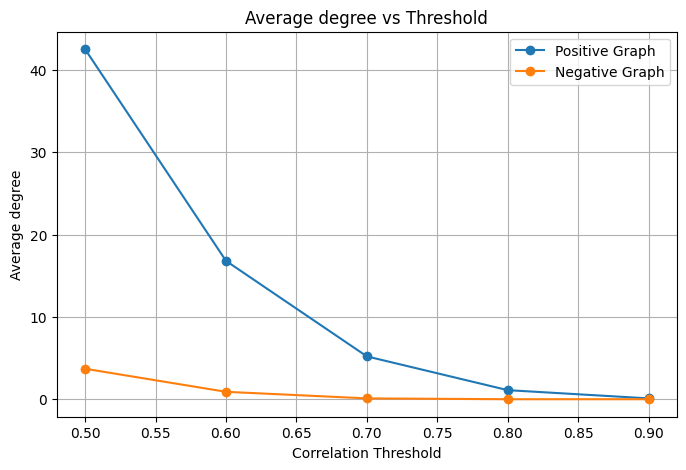

In [22]:
pivot_df = graph_stats_df.pivot(index='Threshold', columns='Graph type', values='Average degree')

plt.figure(figsize=(8, 5))
plt.plot(pivot_df.index, pivot_df['positive'], marker='o', label='Positive Graph')
plt.plot(pivot_df.index, pivot_df['negative'], marker='o', label='Negative Graph')

plt.title('Average degree vs Threshold')
plt.xlabel('Correlation Threshold')
plt.ylabel('Average degree')
plt.grid(True)
plt.legend()
plt.show()

Constructing graphs from the stock correlation matrix works as follows: for each pair of stocks, we compare the correlation value to a given threshold. If the value is positive and above the threshold (for example threshold = 0.7, value = 0.78), we add a corresponding edge to the first graph, and if the value is negative and below the negated threshold (for example threshold = 0.7, value = -0.82), we add the edge to the second graph. This way, the result is two graphs - the first one representing strong positive correlations and the second one representing strong negative correlations. For analysis, we will mostly consider the positive correlation graphs because it makes more sense to analyze positively correlated stocks.

As can be seen from the table and plots above, with threshold values 0.5 and 0.6, there are quite a lot of connections (high degrees, almost all nodes are in largest connected component). And with thresholds 0.8 and 0.9, it is the opposite: very low degrees, largest connected component is very small. Good middle ground seems to be threshold 0.7 - this is what we will be using.

In [24]:
G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, stocks_info, threshold=0.7)
info(G_pos)

       Graph | 'pos_correlations'
       Nodes | 502 (96)
       Edges | 1,313 (0)
      Degree | 5.23 (42)
         LCC | 74.7% (110)
  Clustering | 0.2374



## Visualization

In [6]:
def clustering(G, cluster_def):
  C = {}
  for i, data in G.nodes(data = True):
    c = data[cluster_def]
    if c not in C:
      C[c] = []
    C[c].append(i)
    
  return NodeClustering(list(C.values()), G, 'Known')

In [46]:
algs = {
    "Known": lambda G: clustering(G, cluster_def="sector"),
    #"Graph": lambda G: NodeClustering([range(len(G))],G, 'Graph'),
    #"Isolates": lambda G: NodeClustering([[i] for i in range(len(G))], G, 'Isolates'),
    "MCL": algorithms.markov_clustering,
    "EMMM": lambda G: algorithms.em(G, k = 4), #expectation maximization
    "KL": lambda G: NodeClustering([list(c) for c in nx.community.kernighan_lin_bisection(G)], G, "KL"),
    "Louvain": lambda G: algorithms.louvain(G),
    "Leiden": lambda G: algorithms.leiden(G),
    "Infomap": lambda G: algorithms.infomap(G),
    "LP": lambda G: algorithms.label_propagation(G),
    "FLP": lambda G: NodeClustering([list(c) for c in nx.community.fast_label_propagation_communities(G)], G, "Fast LP")
}

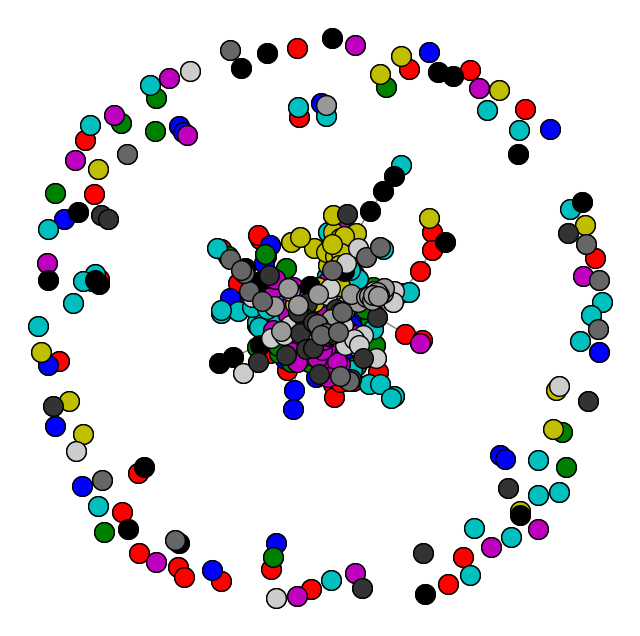

In [43]:
viz.plot_network_clusters(G_pos, algs["Known"](G_pos), nx.spring_layout(G_pos))

We can see that there are a lot of spread-out separated nodes. Lets reduce it to the largest connected component, which we know includes 74.7% of nodes.

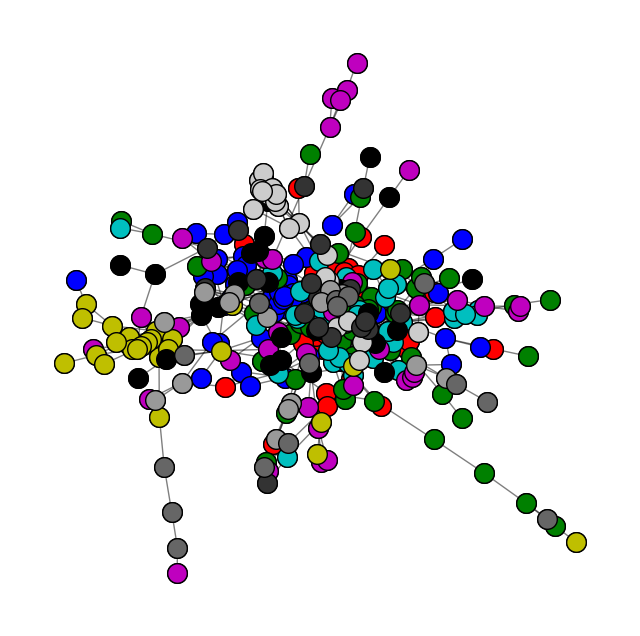

In [12]:
viz.plot_network_clusters(lcc, algs["Known"](lcc), nx.spring_layout(lcc))

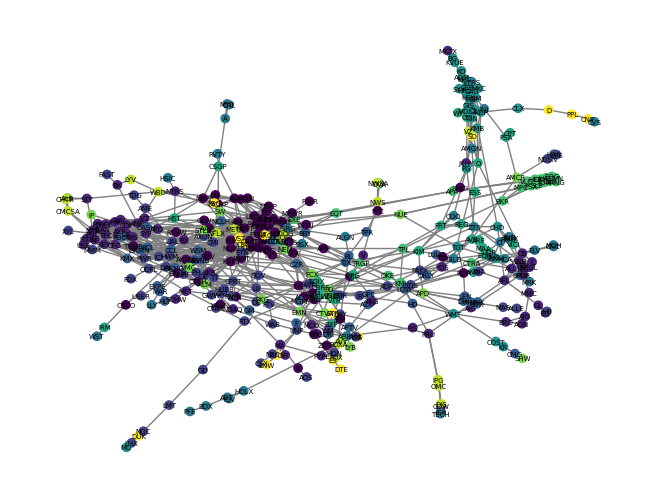

In [10]:
plot_wiring_diagram(lcc, nx.forceatlas2_layout(lcc), algs["Known"](lcc), save_file=False)

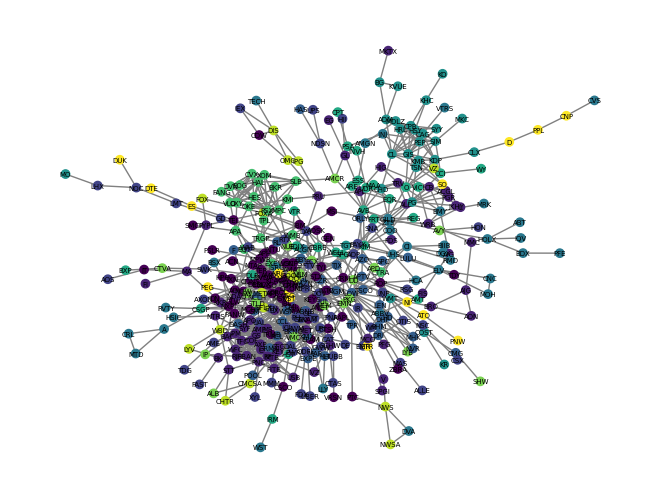

In [11]:
plot_wiring_diagram(lcc, nx.kamada_kawai_layout(lcc), algs["Known"](lcc), save_file=False)

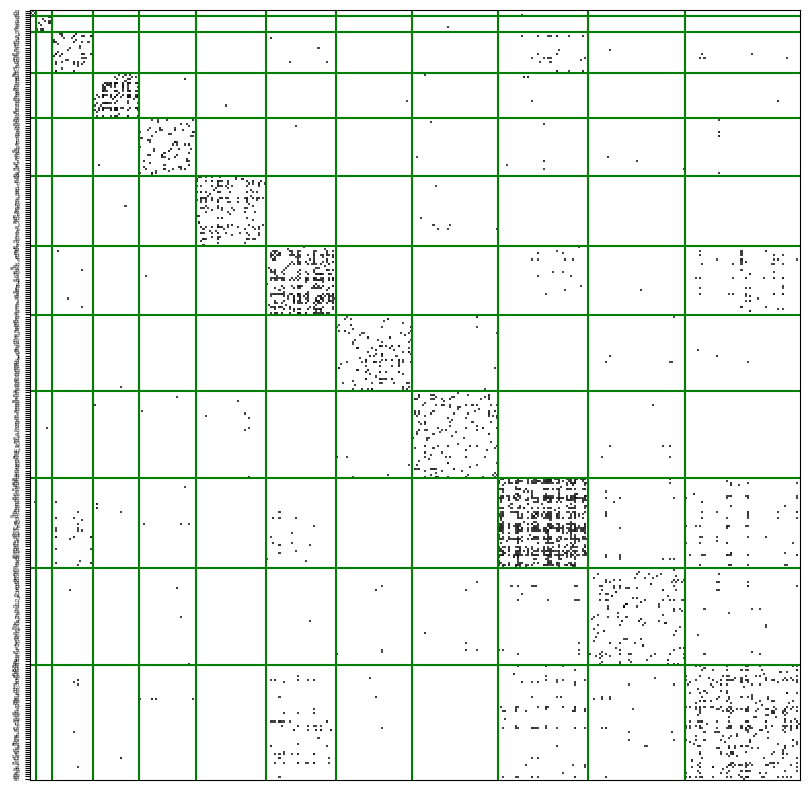

In [13]:
plot_block_model(lcc, algs["Leiden"](lcc), save_file=False)

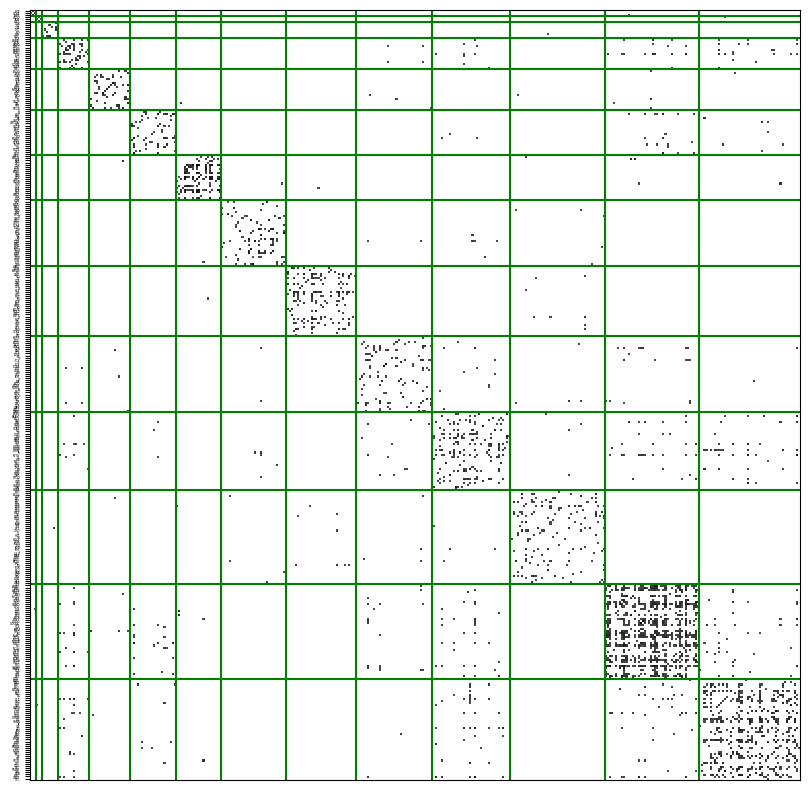

In [15]:
plot_block_model(lcc, algs["Louvain"](lcc), save_file=False)

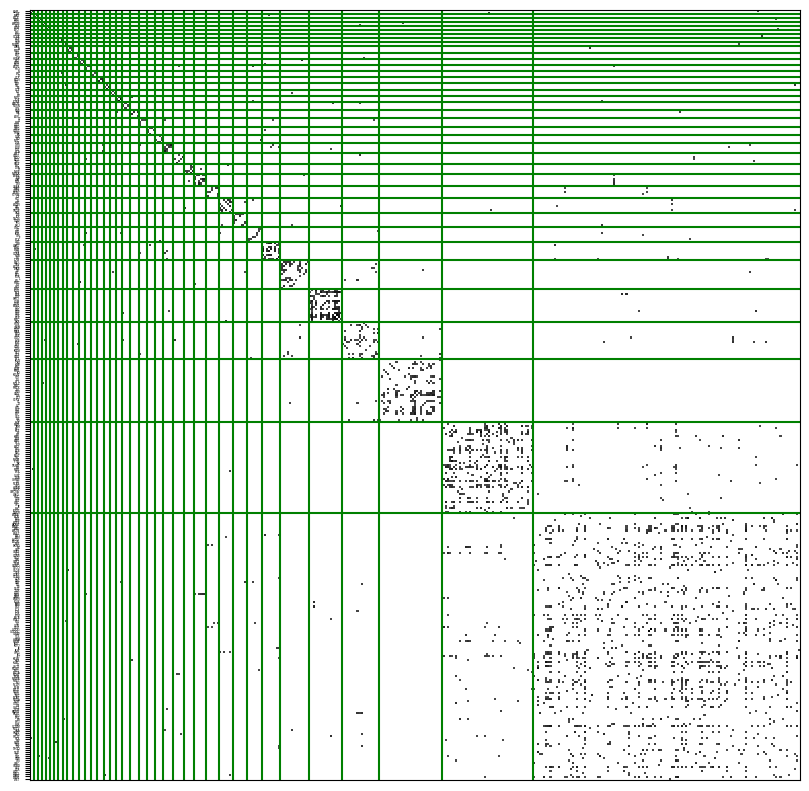

In [18]:
plot_block_model(lcc, algs["FLP"](lcc), save_file=False)

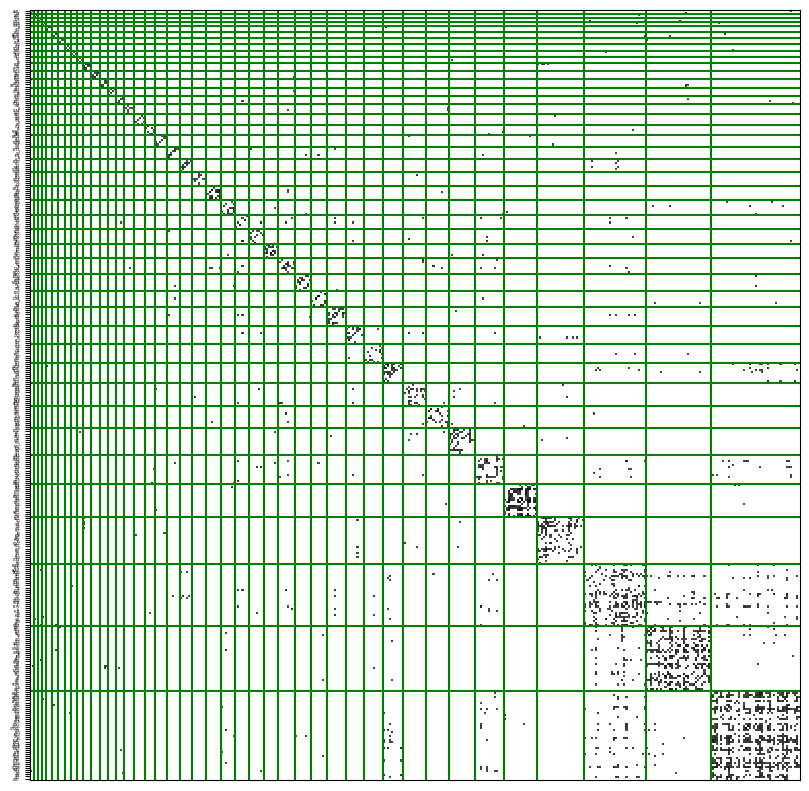

In [19]:
plot_block_model(lcc, algs["Infomap"](lcc), save_file=False)

There are visible communities. Let's compare how well the different community detection algorithms' outputs correspond to the known sectors of the stocks.

## Comparison to ground truth communities

In [56]:
def comparison(G, algs, runs = 1, cluster_def='sector'):
  K = clustering(G, cluster_def)
  
  print("{:>12s} | {:>7s} {:^6s}  {:^5s}  {:^5s}  {:^5s}".format('Algorithm', 'Count', 'Q', 'NMI', 'ARI', 'NVI'))
  
  for alg in algs:
    s, Q, NMI, ARI, NVI = 0, 0, 0, 0, 0
    
    for _ in range(runs):
      C = algs[alg](G)
      s += len(C.communities) / runs
      Q += C.newman_girvan_modularity().score / runs
      NMI += K.normalized_mutual_information(C).score / runs
      ARI += K.adjusted_rand_index(C).score / runs
      NVI += K.variation_of_information(C).score / math.log(len(G)) / runs
      
    print("{:>12s} | {:>7.1f} {:6.3f}  {:5.3f}  {:5.3f}  {:5.3f}".format('\'' + alg + '\'', s, Q, NMI, ARI, NVI))
  print()

In [ ]:
def relabel_to_integers(G):
    mapping = {old_label: new_label for new_label, old_label in enumerate(G.nodes())}
    G_int = nx.relabel_nodes(G, mapping)
    return G_int

# need to make sure that graph's nodes are integers in a range [0, n), otherwise some community detection algorithms dont work...
lcc = relabel_to_integers(lcc)

In [59]:
comparison(lcc, algs)

   Algorithm |   Count   Q      NMI    ARI    NVI 
     'Known' |    11.0  0.341  1.000  1.000  0.000
       'MCL' |    84.0  0.538  0.468  0.139  0.814
      'EMMM' |     4.0  0.066  0.068  0.014  0.766
        'KL' |     2.0  0.365  0.081  0.052  0.666
   'Louvain' |    12.0  0.641  0.292  0.168  0.797
    'Leiden' |    12.0  0.644  0.307  0.174  0.788
   'Infomap' |    46.0  0.608  0.407  0.167  0.836
        'LP' |    49.0  0.430  0.401  0.129  0.738
       'FLP' |    36.0  0.543  0.391  0.166  0.727



The number of communities detected by Louvain and Leiden is the closest to the number of known sectors.

In [60]:
communities = algs["Leiden"](lcc).communities
len(communities)

12

In [63]:
for i, community in enumerate(communities):
    print(f"{i+1}. {len(community)} nodes")

1. 49 nodes
2. 49 nodes
3. 44 nodes
4. 43 nodes
5. 42 nodes
6. 37 nodes
7. 36 nodes
8. 26 nodes
9. 22 nodes
10. 16 nodes
11. 8 nodes
12. 3 nodes


Lets look inside individual communities detected by Leiden.

In [103]:
def investigate_communities(G, communities, printout=True, plot=True):
    num_nodes = []
    most_common_sector_names = []
    most_common_sector_percentages = []
    for i, community in enumerate(communities):
        subgraph = nx.induced_subgraph(G, community)
        subgraph.name = f"community {i+1}"

        sectors_counts = defaultdict(int)
        for _, data in subgraph.nodes(data=True):
            sectors_counts[data["sector"]] += 1
        sectors_counts_sorted = sorted(sectors_counts.items(), key=lambda item: item[1], reverse=True)

        num_nodes.append(len(community))
        most_common_sector_names.append(sectors_counts_sorted[0][0])
        ratio = sectors_counts_sorted[0][1] / len(community)
        most_common_sector_percentages.append(round(ratio * 100, 1))

        if printout:
            info(subgraph)

            subgraph_labels = [data["label"] for _, data in subgraph.nodes(data=True)]
            print("Stocks:", ", ".join(subgraph_labels))
            print()
            for sector, count in sectors_counts_sorted:
                print(f"{sector}: {count}")
            print()

        if plot:
            plot_wiring_diagram(subgraph, nx.forceatlas2_layout(subgraph), save_file=False)

    results = pd.DataFrame({
        "Number of stocks in community": num_nodes,
        "Most common sector": most_common_sector_names,
        "% of stocks in that sector": most_common_sector_percentages
    })
    results.index = [f"Community {i+1}" for i in range(len(communities))]
    return results

       Graph | 'community 1'
       Nodes | 54 (0)
       Edges | 77 (0)
      Degree | 2.85 (9)
         LCC | 100.0% (1)
  Clustering | 0.1765

Stocks: F, NSC, ABBV, FCX, FI, FIS, ADSK, FOX, AIG, FOXA, GEN, GM, GPC, PKG, AOS, PNW, APTV, ATO, PYPL, AZO, RSG, IBM, SPG, CBRE, IT, SPGI, TEL, TJX, TSCO, CRM, TYL, CSX, LYB, UNP, MA, CZR, MCO, DAY, DD, MGM, VTR, WAB, WELL, DRI, DTE, WM, WMB, EMN, ZBRA, EQIX, NDAQ, ES, NI, ETR

Consumer Discretionary: 10
Industrials: 8
Financials: 8
Information Technology: 8
Utilities: 6
Materials: 5
Real Estate: 5
Communication Services: 2
Health Care: 1
Energy: 1



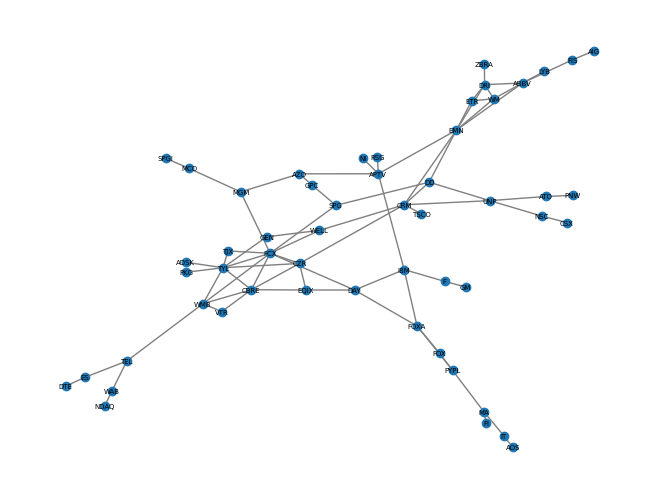

       Graph | 'community 2'
       Nodes | 50 (0)
       Edges | 143 (0)
      Degree | 5.72 (15)
         LCC | 100.0% (1)
  Clustering | 0.3760

Stocks: ABNB, FDX, ACN, FFIV, ODFL, AKAM, FTV, GE, PANW, GEV, AME, PH, GWW, PNR, PWR, HLT, AXON, HUBB, BKNG, HWM, SCHW, CAT, IRM, CCL, JCI, TDG, KEYS, CMI, CPRT, TT, LII, LLY, CSCO, UAL, UBER, CTAS, CTSH, URI, MAR, DAL, VMC, MET, VRSN, DE, MLM, DOV, WSM, WST, EPAM, EXPE

Industrials: 27
Information Technology: 9
Consumer Discretionary: 7
Financials: 2
Health Care: 2
Materials: 2
Real Estate: 1



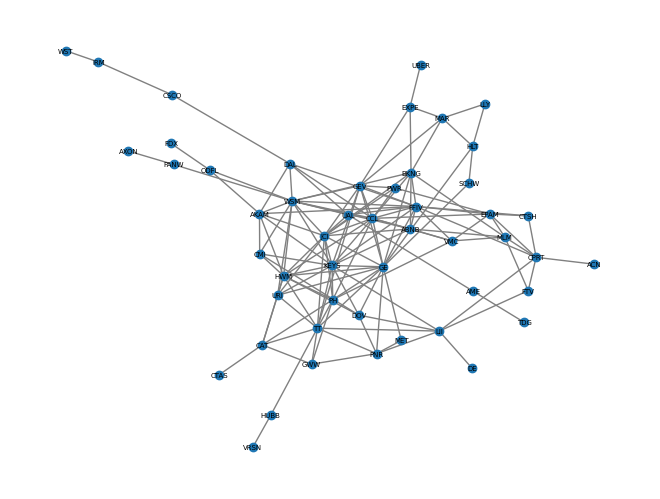

       Graph | 'community 3'
       Nodes | 44 (0)
       Edges | 74 (0)
      Degree | 3.36 (10)
         LCC | 100.0% (1)
  Clustering | 0.2433

Stocks: ABT, ACGL, FDS, ADP, AFL, FRT, ORLY, ALL, PAYX, GILD, GL, PFE, PG, PGR, ARE, AVB, HIG, AVY, HII, HOLX, HON, REG, BDX, BMY, INVH, SNA, IQV, CB, JKHY, CHD, TDY, KIM, COO, TRV, L, UDR, LULU, MAA, VICI, WRB, MRK, EG, ZTS, EQR

Financials: 13
Health Care: 10
Real Estate: 10
Industrials: 5
Consumer Discretionary: 2
Consumer Staples: 2
Materials: 1
Information Technology: 1



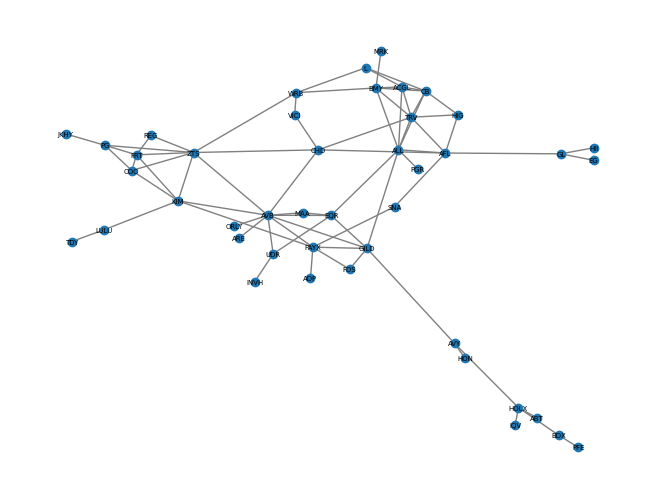

       Graph | 'community 4'
       Nodes | 44 (0)
       Edges | 323 (0)
      Degree | 14.68 (32)
         LCC | 100.0% (1)
  Clustering | 0.6784

Stocks: NTAP, NVDA, FSLR, FTNT, ORCL, AMAT, AMD, GOOG, GOOGL, AMZN, ANET, APH, AVGO, QCOM, HPE, HPQ, BBY, INTU, SNPS, ISRG, CDNS, JBL, CEG, STX, SW, TER, KLAC, CRWD, LRCX, VST, META, DELL, WDC, DLR, MPWR, MSFT, MU, NOW, EQT, NEM, NFLX, ETN, EXE, NRG

Information Technology: 28
Communication Services: 4
Utilities: 3
Consumer Discretionary: 2
Materials: 2
Energy: 2
Health Care: 1
Real Estate: 1
Industrials: 1



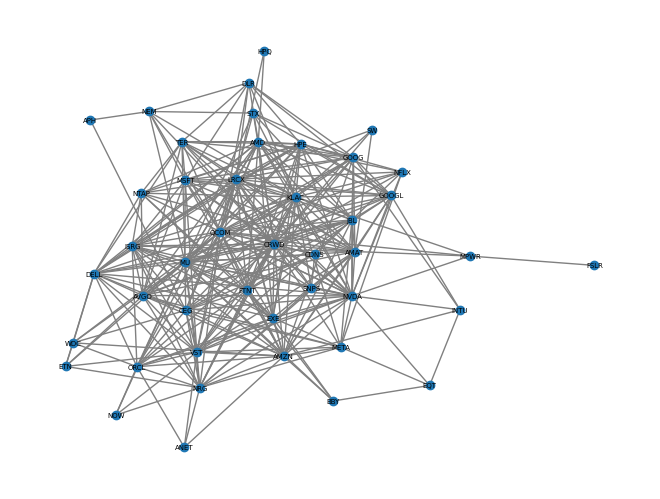

       Graph | 'community 5'
       Nodes | 40 (0)
       Edges | 167 (0)
      Degree | 8.35 (21)
         LCC | 100.0% (1)
  Clustering | 0.5196

Stocks: AAPL, FITB, ALB, GLW, AMP, GRMN, GS, PNC, POOL, APO, HBAN, AXP, RCL, BAC, RF, RJF, BX, IP, C, STLD, IVZ, STT, CFG, JPM, CHTR, KEY, SYF, CMCSA, KKR, TFC, COF, KMX, TRMB, USB, DASH, MMM, WFC, MS, MTB, XYL

Financials: 25
Consumer Discretionary: 5
Information Technology: 3
Materials: 3
Communication Services: 2
Industrials: 2



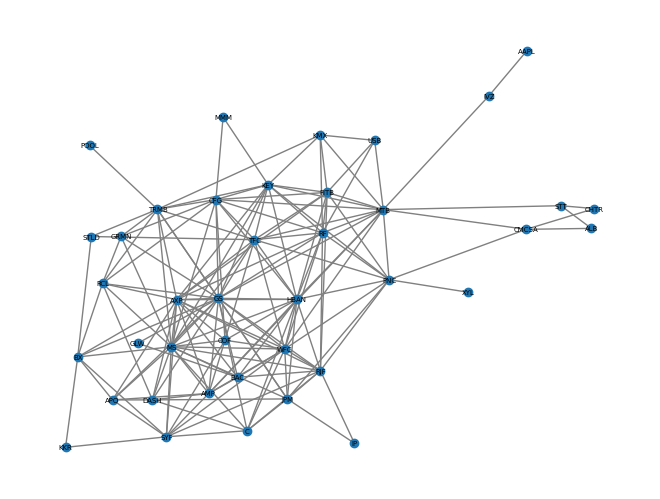

       Graph | 'community 6'
       Nodes | 36 (0)
       Edges | 55 (0)
      Degree | 3.06 (9)
         LCC | 100.0% (1)
  Clustering | 0.3520

Stocks: NVR, AJG, OTIS, ALLE, PFG, AMT, PHM, AON, APD, HCA, HD, RMD, BIIB, ROP, BRO, SHW, IR, CI, CMG, TGT, CNC, COST, KR, LEN, LOW, UHS, CTRA, MAS, MHK, DGX, DHI, MMC, MOH, WMT, ELV, EMR

Health Care: 9
Consumer Discretionary: 8
Financials: 5
Industrials: 5
Consumer Staples: 4
Materials: 2
Real Estate: 1
Information Technology: 1
Energy: 1



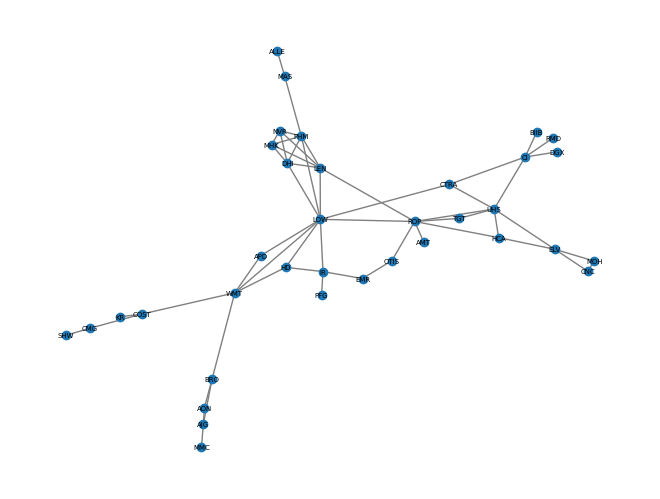

       Graph | 'community 7'
       Nodes | 34 (0)
       Edges | 74 (0)
      Degree | 4.35 (15)
         LCC | 100.0% (1)
  Clustering | 0.3150

Stocks: ADM, O, GIS, PEP, AMGN, PPL, HRL, BG, HSY, SJM, CAG, SO, CCI, JNJ, SYY, KDP, CL, CLX, KHC, KMB, CNP, KO, CPB, KVUE, TSN, CVS, D, MDLZ, VTRS, VZ, MKC, MKTX, WY, ESS

Consumer Staples: 20
Real Estate: 4
Health Care: 4
Utilities: 4
Communication Services: 1
Financials: 1



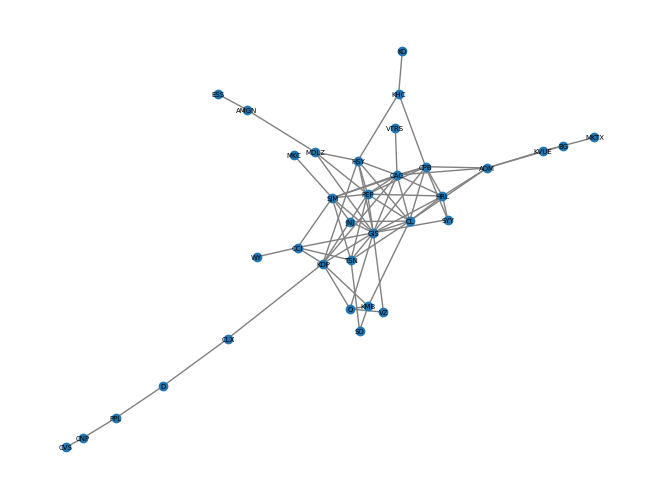

       Graph | 'community 8'
       Nodes | 22 (0)
       Edges | 63 (0)
      Degree | 5.73 (13)
         LCC | 100.0% (1)
  Clustering | 0.5099

Stocks: FANG, NUE, OXY, AMCR, APA, HAL, HAS, PSA, HES, PSX, BKR, SLB, SMCI, CPT, UPS, CVX, VLO, MPC, DVN, XOM, EOG, NDSN

Energy: 14
Materials: 2
Real Estate: 2
Industrials: 2
Consumer Discretionary: 1
Information Technology: 1



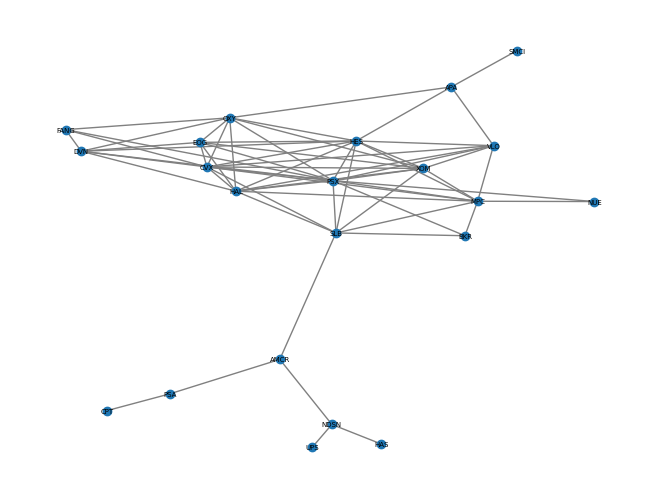

       Graph | 'community 9'
       Nodes | 20 (0)
       Edges | 28 (0)
      Degree | 2.80 (6)
         LCC | 100.0% (1)
  Clustering | 0.3167

Stocks: A, FAST, NTRS, ADI, NXPI, ON, PEG, HSIC, HST, BK, RVTY, INTC, CRL, TXN, CSGP, LYV, MCHP, WBD, MTD, NCLH

Information Technology: 6
Health Care: 5
Financials: 2
Real Estate: 2
Communication Services: 2
Industrials: 1
Utilities: 1
Consumer Discretionary: 1



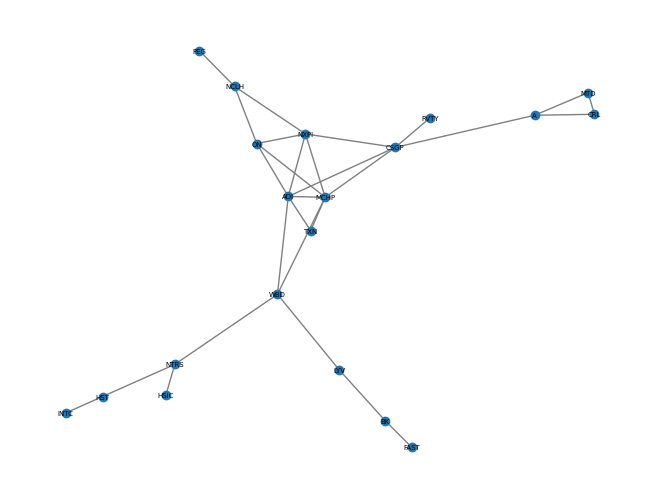

       Graph | 'community 10'
       Nodes | 20 (0)
       Edges | 27 (0)
      Degree | 2.70 (5)
         LCC | 100.0% (1)
  Clustering | 0.4917

Stocks: NWS, NWSA, OKE, OMC, ALGN, PRU, PTC, RL, IEX, BSX, IPG, CDW, TECH, KMI, TPL, TPR, TRGP, V, DIS, DVA

Communication Services: 5
Energy: 4
Health Care: 4
Financials: 2
Information Technology: 2
Consumer Discretionary: 2
Industrials: 1



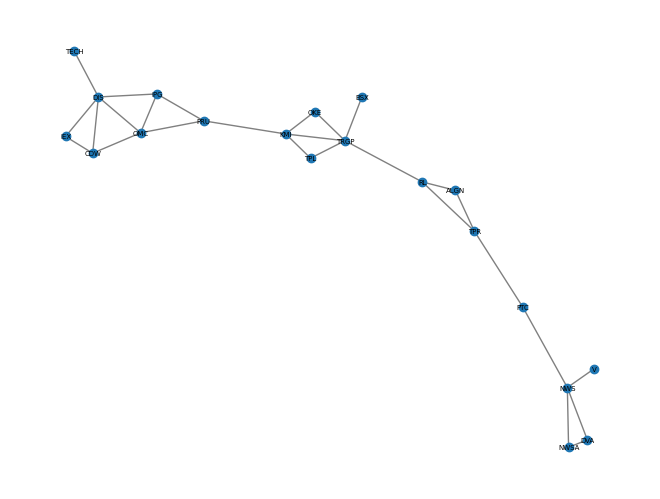

       Graph | 'community 11'
       Nodes | 8 (0)
       Edges | 7 (0)
      Degree | 1.75 (3)
         LCC | 100.0% (1)
  Clustering | 0.0000

Stocks: MO, DUK, GD, RTX, LHX, MSI, LMT, NOC

Industrials: 5
Consumer Staples: 1
Utilities: 1
Information Technology: 1



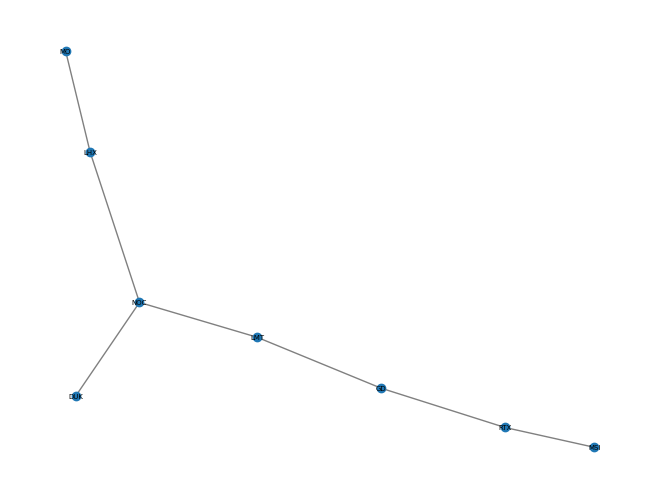

       Graph | 'community 12'
       Nodes | 3 (0)
       Edges | 2 (0)
      Degree | 1.33 (2)
         LCC | 100.0% (1)
  Clustering | 0.0000

Stocks: SWK, CTVA, BXP

Industrials: 1
Materials: 1
Real Estate: 1



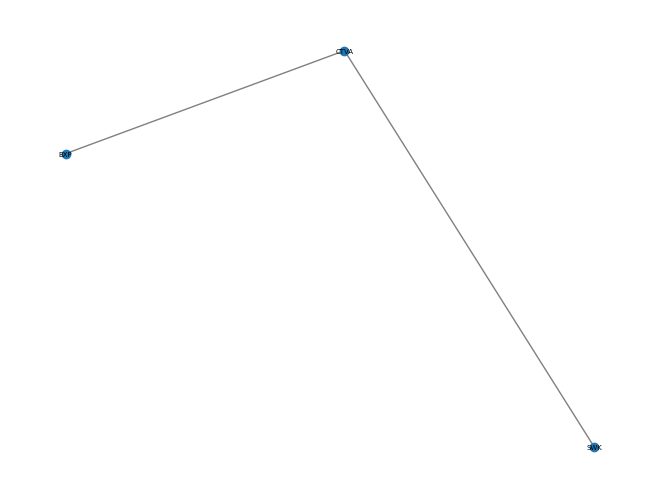

In [104]:
results = investigate_communities(lcc, communities)

In [105]:
results

,Number of stocks in community,Most common sector,% of stocks in that sector
Community 1,54,Consumer Discretionary,18.5
Community 2,50,Industrials,54.0
Community 3,44,Financials,29.5
Community 4,44,Information Technology,63.6
Community 5,40,Financials,62.5
Community 6,36,Health Care,25.0
Community 7,34,Consumer Staples,58.8
Community 8,22,Energy,63.6
Community 9,20,Information Technology,30.0
Community 10,20,Communication Services,25.0


About half of the detected communities have a clear majority sector:
* community 2 - Industrials
* community 4 - Information Technology
* community 5 - Financials
* community 7 - Consumer Staples
* community 8 - Energy
* community 11 - Industrials

Let's do similar investigation for other community detection algorithms, too.

### Louvain

In [106]:
communities = algs["Louvain"](lcc).communities
investigate_communities(lcc, communities, printout=False, plot=False)

,Number of stocks in community,Most common sector,% of stocks in that sector
Community 1,54,Consumer Discretionary,18.5
Community 2,48,Industrials,54.2
Community 3,44,Information Technology,63.6
Community 4,42,Financials,59.5
Community 5,42,Financials,28.6
Community 6,36,Consumer Staples,58.3
Community 7,36,Health Care,25.0
Community 8,22,Energy,63.6
Community 9,20,Information Technology,30.0
Community 10,20,Communication Services,25.0


### Fast Label Propagation

In [108]:
communities = algs["FLP"](lcc).communities
investigate_communities(lcc, communities, printout=False, plot=False)

,Number of stocks in community,Most common sector,% of stocks in that sector
Community 1,146,Information Technology,33.6
Community 2,35,Financials,62.9
Community 3,26,Consumer Staples,69.2
Community 4,17,Energy,82.4
Community 5,15,Real Estate,46.7
Community 6,12,Financials,83.3
Community 7,10,Consumer Discretionary,40.0
Community 8,9,Consumer Discretionary,55.6
Community 9,8,Financials,25.0
Community 10,7,Financials,42.9


### Markov Clustering

In [113]:
communities = algs["MCL"](lcc).communities
results = investigate_communities(lcc, communities, printout=False, plot=False)
results[results["Number of stocks in community"] > 4]

,Number of stocks in community,Most common sector,% of stocks in that sector
Community 1,40,Information Technology,57.5
Community 2,31,Financials,71.0
Community 3,20,Consumer Staples,70.0
Community 4,13,Consumer Discretionary,38.5
Community 5,13,Energy,100.0
Community 6,10,Financials,80.0
Community 7,10,Real Estate,40.0
Community 8,7,Energy,57.1
Community 9,7,Communication Services,42.9
Community 10,6,Information Technology,50.0


### Infomap

In [ ]:
communities = algs["Infomap"](lcc).communities
results = investigate_communities(lcc, communities, printout=False, plot=False)
results[results["Number of stocks in community"] > 4]

,Number of stocks in community,Most common sector,% of stocks in that sector
Community 1,45,Information Technology,60.0
Community 2,37,Industrials,54.1
Community 3,27,Financials,81.5
Community 4,24,Consumer Staples,70.8
Community 5,16,Energy,87.5
Community 6,13,Financials,69.2
Community 7,12,Real Estate,33.3
Community 8,11,Real Estate,63.6
Community 9,11,Health Care,45.5
Community 10,9,Financials,22.2


Looks like most of these algorithms successfully detect communities of stocks that often have one clear majority sector. However, only Louvain and Leiden detect communities that are broad enough to correspond with known sectors. Other algorithms detect many more communities that are smaller, so those might correspond to sub-industries of stocks. (**TODO**: add Sub-Industry column to tables above to confirm this?)